In [1]:
from ppget.source import ModelSource

start_date = "2007-07-01"
end_date = "2008-07-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [2]:
series = source.series()
series.head()

timestamp
2007-07-01 00:00:00    2.6812
2007-07-01 00:10:00    2.6502
2007-07-01 00:20:00    2.6266
2007-07-01 00:30:00    2.5242
2007-07-01 00:40:00    2.6000
Freq: 10T, Name: Global_active_power, dtype: float64

In [3]:
from ppget.datastructure import DatasetBuilder, TrainSplit

WINDOW = 4
MODEL_NAME = "model/gru/"

builder = DatasetBuilder(series, data_split=TrainSplit(), window_size=WINDOW)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((47430, 4, 1), (47430,), (5270, 4, 1), (5270,))

In [4]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Dense, GRU, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(InputLayer((WINDOW, 1)))
model.add(GRU(64, dropout=0.05))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))
callbacks = [ModelCheckpoint(MODEL_NAME, monitor="val_loss", save_best_only=True, mode="min"), EarlyStopping(patience=5, monitor="val_loss")]
model.compile(loss="mse", optimizer="adam", metrics=[RootMeanSquaredError()])
model.summary()

2022-06-04 11:18:13.079005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12672     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [5]:
%%time
h = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=25,
                    batch_size=8,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=callbacks)
print(f"min RMSE(validation): {min(h.history['val_loss'])}")

Epoch 1/25
4743/4743 - 18s - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
INFO:tensorflow:Assets written to: model/gru/assets
Epoch 2/25
4743/4743 - 17s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 3/25
4743/4743 - 12s - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 4/25
4743/4743 - 9s - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 5/25
4743/4743 - 10s - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 6/25
4743/4743 - 10s - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
INFO:tensorflow:Assets written to: model/gru/assets
Epoch 7/25
4743/4743 - 11s - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0035 - va

In [6]:
%%time
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

CPU times: user 1.45 s, sys: 75 ms, total: 1.52 s
Wall time: 1.38 s


5270

In [7]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results.head()

,Predictions,Ground Truth
0,0.084841,0.071953
1,0.081599,0.076587
2,0.087731,0.065371
3,0.073362,0.061949
4,0.069898,0.077062


In [10]:
from ppget.metrics import ModelEvaluation

print(ModelEvaluation(expected=test_results["Ground Truth"][:-1],
                      predicted=test_results["Predictions"].shift(-1)[:-1],
                      m=1,
                      model_path=MODEL_NAME,
                      builder=builder))

Model Scores - (R2): 0.966, (Adj R2): 0.966, (RMSE): 0.266 KW. Model Size - 777661 bytes.


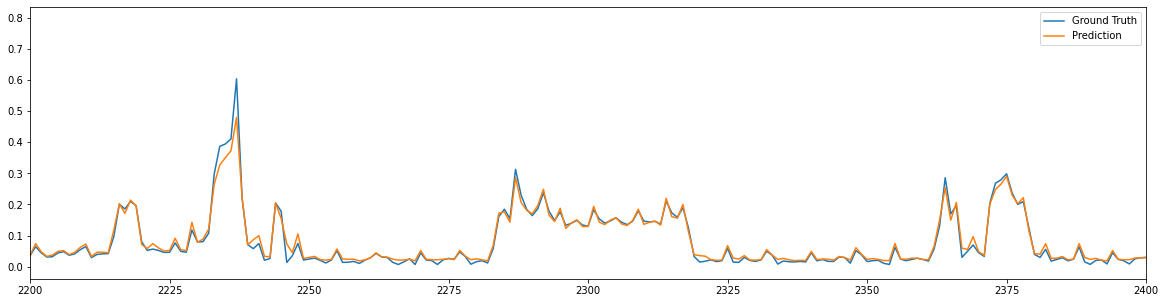

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test_results["Ground Truth"], label="Ground Truth")
ax.plot(test_results["Predictions"].shift(-1), label="Prediction")

plt.legend(["Ground Truth", "Prediction"])
plt.xlim([2200, 2400])
plt.show()